# [Exp10]WordTranslator

## 개요

* 글자 단위(Character-level) -> 단어 단위(Word-level)
* 동일한 Dataset
* 글자 단위와는 다른 전처리
* 임베딩 층 추가
* 단어장의 크기가 커지므로 학습 속도도 좀 더 느려집니다.
* 데이터에서 상위 33000개의 샘플만 사용
* 이중 3천개는 테스트 데이터로 분리하여 모델을 학습한 후 테스트하는 용도로 사용

## Library 불러오기

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

## Data 불러오기

### Data를 불러옵니다.

In [2]:
file_path = 'data/fra.txt'
df_data = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
len(df_data)
df_data.sample(5)

,eng,fra,cc
151371,"Could you change these for me, please?",Pouvez-vous changer cela pour moi s'il vous pl...,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
119448,Why don't you consult a lawyer?,Pourquoi ne consultez-vous pas un avocat ?,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
71118,I prefer plain materials.,Je préfère les matières simples.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1400,Seriously?,Vraiment ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
80523,Luckily nobody got killed.,Heureusement personne n'a été tué.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...


### CC 제거 및 33000개 사용

In [3]:
df_data = df_data[['eng', 'fra']][:33000]
df_data.sample(5)

,eng,fra
12695,You must do it.,Vous devez le faire.
9862,Don't stop him.,Ne l'arrêtez pas.
19376,I've lost my key.,J'ai perdu ma clef.
26148,This is her house.,C'est sa maison.
5475,It's for you.,C'est pour toi.


## Step 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

### 1. 구두점(Punctuation)을 단어와 분리해주세요.

* 구두점의 종류 : ' ! , : . - ?; "
* 여기서에서 ' " 를 제외하고 구두점을 분리해보겠습니다.

In [4]:
df_data.head(10)

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.
5,Run!,Cours !
6,Run!,Courez !
7,Run!,Prenez vos jambes à vos cous !
8,Run!,File !
9,Run!,Filez !


In [5]:
df_updated = df_data.replace(to_replace=r'([!,:.-?;])', value = r' \1 ', regex = True)

In [6]:
df_updated.head(10)

,eng,fra
0,Go .,Va !
1,Go .,Marche .
2,Go .,Bouge !
3,Hi .,Salut !
4,Hi .,Salut .
5,Run !,Cours !
6,Run !,Courez !
7,Run !,Prenez vos jambes à vos cous !
8,Run !,File !
9,Run !,Filez !


### 2. 소문자로 바꿔주세요.

* [pandas.Series.str.lower](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.lower.html)

In [7]:
df_updated['eng'] = df_updated['eng'].str.lower()
df_updated['fra'] = df_updated['fra'].str.lower()


In [8]:
df_updated

,eng,fra
0,go .,va !
1,go .,marche .
2,go .,bouge !
3,hi .,salut !
4,hi .,salut .
...,...,...
32995,what did tom steal ?,qu'est-ce que tom a volé ?
32996,what did tom write ?,qu'est-ce que tom a écrit ?
32997,what did they want ?,que voulaient-ils ?
32998,what did they want ?,que voulaient-elles ?


### 3. 띄어쓰기 단위로 토큰을 수행하세요.

* [pandas.Series.str.split](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.split.html)

In [9]:
df_updated['eng'] = df_updated['eng'].str.split()
df_updated['fra'] = df_updated['fra'].str.split()
df_updated

,eng,fra
0,"[go, .]","[va, !]"
1,"[go, .]","[marche, .]"
2,"[go, .]","[bouge, !]"
3,"[hi, .]","[salut, !]"
4,"[hi, .]","[salut, .]"
...,...,...
32995,"[what, did, tom, steal, ?]","[qu'est-ce, que, tom, a, volé, ?]"
32996,"[what, did, tom, write, ?]","[qu'est-ce, que, tom, a, écrit, ?]"
32997,"[what, did, they, want, ?]","[que, voulaient-ils, ?]"
32998,"[what, did, they, want, ?]","[que, voulaient-elles, ?]"


## Step 2. 시작과 종료 토큰 추가

* [시퀀스 객체 연결하기 방법](https://dojang.io/mod/page/view.php?id=2205)을 활용하여 문장의 앞과 뒤에 토큰을 추가합니다.

In [10]:
sos_token = '\t'
eos_token = '\n'
df_updated.fra = df_updated.fra.apply(lambda x : [sos_token] + x + [eos_token])

## Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요.

### 영어 Tokenizer

* [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)
* 영어부터 토큰화해보겠습니다.

In [11]:
eng_tokenizer = Tokenizer(filters='') 
eng_tokenizer.fit_on_texts(df_updated.eng)
input_text = eng_tokenizer.texts_to_sequences(df_updated.eng)
input_text[:3]

[[26, 1], [26, 1], [26, 1]]

In [12]:
display(df_updated.eng[:3])
print(eng_tokenizer.word_index['.']  )

0    [go, .]
1    [go, .]
2    [go, .]
Name: eng, dtype: object

1


### 프랑스어 Tokenizer

In [13]:
fra_tokenizer = Tokenizer(filters='')
fra_tokenizer.fit_on_texts(df_updated.fra)
target_text = fra_tokenizer.texts_to_sequences(df_updated.fra)
target_text[:3]

[[1, 63, 7, 2], [1, 360, 3, 2], [1, 713, 7, 2]]

In [14]:
display(df_updated.fra[:3])
print(eng_tokenizer.word_index['!']  )

0        [\t, va, !, \n]
1    [\t, marche, ., \n]
2     [\t, bouge, !, \n]
Name: fra, dtype: object

20


## Step 4. 임베딩 층(Embedding layer) 사용하기

### 단어장의 크기

In [15]:
eng_tokenizer.word_counts

OrderedDict([('go', 802),
             ('.', 27844),
             ('hi', 14),
             ('run', 70),
             ('!', 1030),
             ('who', 242),
             ('?', 4151),
             ('wow', 5),
             ('duck', 3),
             ('fire', 17),
             ('help', 276),
             ('hide', 9),
             ('jump', 16),
             ('stop', 285),
             ('wait', 118),
             ('begin', 13),
             ('on', 414),
             ('hello', 16),
             ('i', 6293),
             ('see', 229),
             ('try', 189),
             ('won', 56),
             ('oh', 12),
             ('no', 614),
             ('relax', 23),
             ('smile', 16),
             ('sorry', 46),
             ('attack', 15),
             ('buy', 52),
             ('it', 2412),
             ('cheers', 4),
             ('eat', 141),
             ('get', 457),
             ('up', 446),
             ('now', 296),
             ('got', 284),
             ('hop', 2),
          

In [16]:
eng_vocab_size = len(eng_tokenizer.word_counts) + 1
fra_vocab_size = len(fra_tokenizer.word_counts) + 1
print(eng_vocab_size, fra_vocab_size)
emb_vector_num = 256
hidden_size = 256

4788 9972


### Encoder

In [17]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Input, Embedding, Masking

encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, emb_vector_num)(encoder_inputs)
encoder_lstm = LSTM(hidden_size, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

2022-08-26 23:45:03.434161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-26 23:45:04.059083: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6333 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


### Decoder

In [18]:
decoder_inputs = Input(shape=(None,))
fra_emb =  Embedding(fra_vocab_size, emb_vector_num)(decoder_inputs)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(fra_emb, initial_state = encoder_states)

In [19]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

## 모델 구현하기

* Encoder 와 Decoder 연결

In [20]:
from tensorflow.keras.models import Model

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    1225728     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    2552832     ['input_2[0][0]']                
                                                                                              

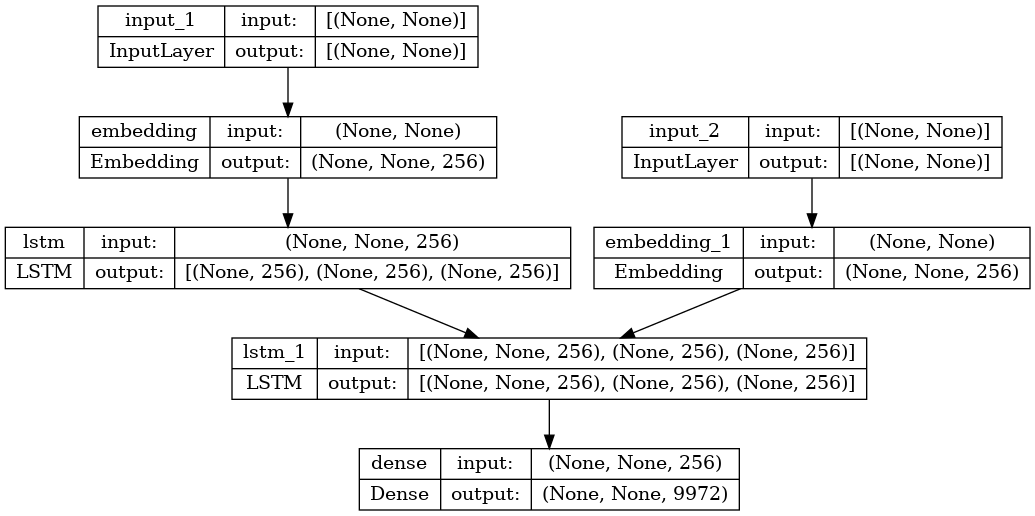

In [21]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

## 모델 훈련

In [22]:
encoder_input = input_text
decoder_input = [[ x for x in line if x != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
decoder_target = [[ x for x in line if  x != fra_tokenizer.word_index[sos_token] ] for line in target_text]

* Padding을 진행합니다.

In [23]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

encoder_input = pad_sequences(encoder_input, padding='post')
decoder_input = pad_sequences(decoder_input, padding='post')
decoder_target = pad_sequences(decoder_target, padding='post')

In [24]:
decoder_input.shape

(33000, 16)

In [25]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]


print(np.shape(encoder_input))
print(np.shape(decoder_input))
print(np.shape(decoder_target))


(33000, 11)
(33000, 16)
(33000, 16)


In [26]:
encoder_input_test.shape, decoder_input_test.shape, decoder_target_test.shape

((3000, 11), (3000, 16), (3000, 16))

In [27]:
for i in target_text:
    if len(i) == 0:
        print(i)


In [28]:
df_updated.eng[:10]

0     [go, .]
1     [go, .]
2     [go, .]
3     [hi, .]
4     [hi, .]
5    [run, !]
6    [run, !]
7    [run, !]
8    [run, !]
9    [run, !]
Name: eng, dtype: object

In [29]:
encoder_input[:10]

array([[ 26,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 26,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 26,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [790,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [790,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [211,  20,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [211,  20,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [211,  20,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [211,  20,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [211,  20,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int32)

In [30]:
encoder_input_test

array([[ 2, 48, 23, ...,  0,  0,  0],
       [ 2, 48, 23, ...,  0,  0,  0],
       [ 2, 48, 23, ...,  0,  0,  0],
       ...,
       [41, 34, 29, ...,  0,  0,  0],
       [41, 34, 29, ...,  0,  0,  0],
       [41, 34,  4, ...,  0,  0,  0]], dtype=int32)

In [31]:
decoder_input_test

array([[   1,    4,   65, ...,    0,    0,    0],
       [   1,    4,   65, ...,    0,    0,    0],
       [   1,    4,   65, ...,    0,    0,    0],
       ...,
       [   1,   27, 9970, ...,    0,    0,    0],
       [   1,   27, 9971, ...,    0,    0,    0],
       [   1,  727,  647, ...,    0,    0,    0]], dtype=int32)

In [32]:
decoder_target_test.shape

(3000, 16)

In [33]:
pd.DataFrame(decoder_target_test).isna().sum()
# , decoder_input_test.shape, decoder_target_test.shape

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
dtype: int64

In [34]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

# model.fit(x=[encoder_input, decoder_input], y=decoder_target, \
#           validation_rate = 0.2,
#           batch_size=128, epochs=50)

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=128, epochs=50)

Epoch 1/50


2022-08-26 23:45:09.758204: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


235/235 [==============================] - 9s 20ms/step - loss: 1.7971 - val_loss: 1.7071
Epoch 2/50
235/235 [==============================] - 4s 18ms/step - loss: 1.2699 - val_loss: 1.4894
Epoch 3/50
235/235 [==============================] - 4s 18ms/step - loss: 1.1170 - val_loss: 1.3810
Epoch 4/50
235/235 [==============================] - 4s 18ms/step - loss: 1.0197 - val_loss: 1.3118
Epoch 5/50
235/235 [==============================] - 4s 18ms/step - loss: 0.9465 - val_loss: 1.2751
Epoch 6/50
235/235 [==============================] - 4s 18ms/step - loss: 0.8881 - val_loss: 1.2267
Epoch 7/50
235/235 [==============================] - 4s 18ms/step - loss: 0.8381 - val_loss: 1.2071
Epoch 8/50
235/235 [==============================] - 4s 18ms/step - loss: 0.7965 - val_loss: 1.1799
Epoch 9/50
235/235 [==============================] - 4s 18ms/step - loss: 0.7603 - val_loss: 1.1640
Epoch 10/50
235/235 [==============================] - 4s 18ms/step - loss: 0.7269 - val_loss: 1.1430


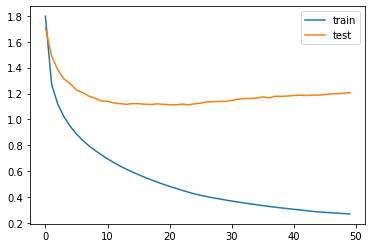

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 모델 평가

In [37]:
# encoder_inputs = Input(shape=(None,), name = 'encIn2')
# enc_emb =  Embedding(eng_vocab_size, emb_vector_num, name = 'encEmb2')(encoder_inputs)
# encoder_lstm = LSTM(hidden_size, return_state=True, name = 'encLstm2')
# encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# encoder_states = [state_h, state_c]

# decoder_inputs = Input(shape=(None,))
# fra_emb =  Embedding(fra_vocab_size, emb_vector_num)(decoder_inputs)
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True)
# decoder_outputs, _, _ = decoder_lstm(fra_emb, initial_state = encoder_states)

# decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
# decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

In [38]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         1225728   
                                                                 
 lstm (LSTM)                 [(None, 256),             525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 1,751,040
Trainable params: 1,751,040
Non-trainable params: 0
_________________________________________________________________


In [39]:

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(fra_emb, initial_state = decoder_states_inputs)
decoder_states = [state_h, state_c]

In [40]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    2552832     ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                            

In [41]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [42]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 상태를 얻음
  states_value = encoder_model.predict(input_seq)
  
  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = fra_tokenizer.word_index[sos_token]

  stop_condition = False
  decoded_sentence = ""

  # stop_condition이 True가 될 때까지 루프 반복
  while not stop_condition:
      # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
      output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

      # 예측 결과를 문자로 변환
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_char = fra_tokenizer.index_word[sampled_token_index]

      # 현재 시점의 예측 문자를 예측 문장에 추가
      decoded_sentence += sampled_char + ' '

      # <eos>에 도달하거나 최대 길이를 넘으면 중단.
      if (sampled_char == eos_token or
          len(decoded_sentence) > 16):
          stop_condition = True

      # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
      target_seq = np.zeros((1, 1))
      target_seq[0, 0] =  sampled_token_index

      # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
      states_value = [h, c]

  return decoded_sentence

In [44]:
import numpy as np
for seq_index in [100,200,300,400,500,1000]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', df_updated.eng[seq_index])
    print('정답 문장:', df_updated.fra[seq_index][1:len(df_updated.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

1/1 [==============================] - 0s 17ms/step
-----------------------------------
입력 문장: ['hop', 'in', '.']
정답 문장: ['montez', '.']
번역기가 번역한 문장: montez . 

1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: ['call', 'us', '.']
정답 문장: ['appelle-nous', '!']
번역기가 번역한 문장: ! 

1/1 [==============================] - 0s 18ms/step
-----------------------------------
입력 문장: ['help', 'me', '!']
정답 문장: ['aide-moi', '!']
번역기가 번역한 문장: aide-moi ! 

1/1 [==============================] - 0s 12ms/step
-----------------------------------
입력 문장: ['sign', 'up', '.']
정답 문장: ['inscrivez-vous', '.']
번역기가 번역한 문장: le qui . 

1/1 [==============================] - 0s 19ms/step
-----------------------------------
입력 문장: ['get', 'away', '!']
정답 문장: ['bouge', '!']
번역기가 번역한 문장: dégage ! 

1/1 [==============================] - 0s 16ms/step
-----------------------------------
입력 문장: ["how's", 'tom', '?']
정답 문장: ['comment', 'va', 'tom', '?']
번역기가 번역한 문장: comment va to

## 회고

* 이번 프로젝트에서 어려웠던 점
    - matrix 크기 또는 모델에서 맞춰줘야하는 사이즈의 크기가 한눈에 들어오지 않아 생각하기 힘들었다.
* 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
  * 알게 된 점
    - 0 값을 위한 1을 더해야한다.
  * 아직 모호한 점
    - 출력 부분
* 루브릭 평가를 맞추기 위해 시도한 점
    - 그래프 그리기
    - 전처리 확인